In [1]:
import os

import geopandas as gpd
import numpy as np
import openeo
import pandas as pd
import plotly.express as px
import rasterio
from scipy.signal import savgol_filter

## How to use GeoPandas and OpenEo

This notebook shows some of the functions, libraries and file formats we use in the chapter, in case you're not familiar with them.

GeoPandas is a library to work with tables holding geographic information. This geographic information is represented by sets of coordinates, which can define points, lines or polygons (or multi-polygons).

Geopackage is a file type (`.gpkg`) that can hold layers of geographical information. In our case, the notebook in `/data_preparation` created a `.gpkg` with polygon/multipolygon geometries (Paris' parks) and a layer f points (Paris's Parks centroids).

We can explore the `.gpkg` file with GeoPandas and the `list_layers` method:

In [2]:
geopackage_path = "../src/data/paris_parks.gpkg"

layer_names = gpd.list_layers(geopackage_path)

print(layer_names)

              name geometry_type
0   parks_polygons  MultiPolygon
1  parks_centroids         Point


We can uise each layer to create a GeoPandas GeoDataFrame. GepDataFrames have tabular data (just like a pandas DataFrame), but also geographic information. Each column in the GeoDataFrame is an **attribute** of the geographical object (for example, `postal_code` is an attribute of Paris' parks):

In [3]:
gdf_paris_parks = gpd.read_file(geopackage_path, layer="parks_polygons")
gdf_park_centroid = gpd.read_file(geopackage_path, layer="parks_centroids")

In [4]:
gdf_paris_parks.head()

,id,id_name,name,postal_code,type,category,perimeter,total_real_surface,has_fence,area_sqm,geometry
0,5,5 - Jardins Des Champs Elysees- Jardin Line Re...,Jardins Des Champs Elysees- Jardin Line Renaud,75008,Open Promenades,Garden,NaN,NaN,0.0,19219,"MULTIPOLYGON (((2.31728 48.86799, 2.31763 48.8..."
1,13,13 - Jardin Monique Wittig,Jardin Monique Wittig,75014,Open Promenades,Small Garden,230.0,996.0,0.0,1391,"MULTIPOLYGON (((2.30574 48.82854, 2.30571 48.8..."
2,14,14 - Promenade Pc 18 - Ornano - Poissonniers,Promenade Pc 18 - Ornano - Poissonniers,75018,Open Promenades,Promenade,NaN,13440.0,1.0,9620,"MULTIPOLYGON (((2.35279 48.89807, 2.35268 48.8..."
3,18,18 - Jardin De La Rue Compans,Jardin De La Rue Compans,75019,Open Promenades,Garden,244.0,2444.0,1.0,2386,"MULTIPOLYGON (((2.39199 48.87815, 2.39272 48.8..."
4,19,19 - 00-06,00-06,75013,Ring Road,Slope,258.0,NaN,0.0,1890,"MULTIPOLYGON (((2.38683 48.8251, 2.38696 48.82..."


Just like pandas, GeoPandas has a `.plot()` method, it "knows" what to plot. `gdf_paris_parks` has polygons, and `gdf_park_centroid` has points:

In [5]:
id_vincennes = "1679 - Bois De Vincennes"
gdf_paris_parks[gdf_paris_parks["id_name"] == id_vincennes]

,id,id_name,name,postal_code,type,category,perimeter,total_real_surface,has_fence,area_sqm,geometry
532,1679,1679 - Bois De Vincennes,Bois De Vincennes,75012,Woods,Woods,21984.0,NaN,0.0,9928813,"MULTIPOLYGON (((2.41134 48.83384, 2.41194 48.8..."


<Axes: >

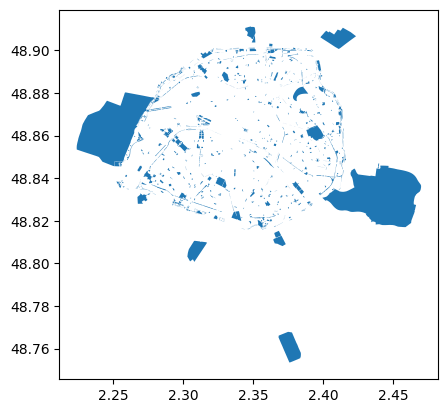

In [6]:
gdf_paris_parks.plot()

<Axes: >

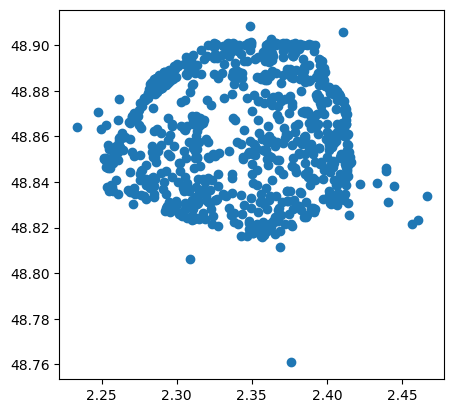

In [7]:
gdf_park_centroid.plot()

## Ploting with Plotly

We can plot GeoDataFrames with Plotly.
Since we have centroids for each polygon, we can use them to center the map around them!

In [8]:
def plot_park_with_centroid(
    gdf_parks, gdf_park_centroid, id_name, map_style="open-street-map"
):
    """
    Plots a specific park with its centroid on a Plotly map.

    Args:
        gdf_parks (geopandas.GeoDataFrame): GeoDataFrame containing park polygons.
        gdf_park_centroid (geopandas.GeoDataFrame): GeoDataFrame containing park centroids.
        id_name (str): The name and ID of the park to plot.
        map_style (str, optional): Map style. Defaults to "open-street-map".

    Returns:
        plotly.graph_objects.Figure: A Plotly map figure, or None if the park is not found.
    """
    park_polygon = gdf_parks[gdf_parks["id_name"] == id_name].copy()

    id = int(id_name.split("-", 1)[0])
    park_centroid = gdf_park_centroid[gdf_park_centroid["id"] == id].copy()

    if park_polygon.empty or park_centroid.empty:
        return None

    # Get centroid coordinates
    centroid_point = park_centroid["geometry"].iloc[0]
    center = {"lat": centroid_point.y, "lon": centroid_point.x}

    fig = px.choropleth_map(
        park_polygon,
        geojson=park_polygon.geometry.__geo_interface__,
        locations=park_polygon.index,
        center=center,
        map_style=map_style,
        zoom=15,
        opacity=0.5,
        hover_name="name",
        hover_data={
            "name": True,
            "type": True,
            "category": True,
            "area_sqm": True,
        },
    )

    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return fig

In [9]:
plot_park_with_centroid(
    gdf_parks=gdf_paris_parks,
    gdf_park_centroid=gdf_park_centroid,
    id_name=id_vincennes,
    map_style="open-street-map",
)

## Converting to DataFrame

In case you need it, you can convert a GeoDataFrame into a DataFrame:

In [10]:
df_paris_parks = pd.DataFrame(gdf_paris_parks)

In [11]:
df_paris_parks.groupby("type").size().reset_index(name="count")

,type,count
0,Cemeteries,20
1,Decorative Gardens,27
2,Open Promenades,496
3,Private Gardens,9
4,Ring Road,139
5,Sports Facilities,14
6,Street Decorations,64
7,"Temporary, Shared, Educational Spaces",8
8,Woods,2


## OpenEO

[OpenEO](https://pypi.org/project/openeo/) ("EO" for Earth Observation) is a Python library that provides an API to interact with backends that serve geographic information.

For our app, we'll be using Sentinel-2 data, from the European Space Agency (ESA).

**You need to create an account: https://dataspace.copernicus.eu/**.

![](../img/account.png)

**You'll also need to create credentials**:

* Go to your account's settings (likely: https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings)


### Important resources:

* [OpenEO's documentation about datacubes, the most important concept to understand the app's algorithms](https://openeo.org/documentation/1.0/datacubes.html#what-are-datacubes]).

* [Notebooks to chek out]( https://dataspace.copernicus.eu/cases).

## Defining functions

These are the functions we use in the pipelines, for pour Scenario and also for our Generic Data Nodes.

The first one retrieves a Polygon from our previou GeoDataFrame:

In [12]:
def get_polygon(gdf_paris_parks, id_name):
    polygon = gdf_paris_parks[
        gdf_paris_parks["id_name"] == id_name
    ].geometry.__geo_interface__
    return polygon

**IMPORTANT:** This function returns the connector to our Copernicus's space. You'll need to provide your credentials.

**We highly recommend using environment variables to store your credentials!**

In [13]:
def connect_to_copernicus(
    client_id, client_secret, url="https://openeo.dataspace.copernicus.eu"
):
    connection = openeo.connect(url)
    connection.authenticate_oidc_client_credentials(
        client_id=client_id, client_secret=client_secret
    )
    return connection

A **datacube** holds the following dimensions:

* **Time**: we need to provide the time extent for the Earth's Observations. Sentinel 2 goes over each spot on Earth every 3 days more or less. Each observation is one picture from the satellite.
* **Spatial Extent**: The surface of the observed area. Bigger surfaces give more pixels.
* **Spectral resolution:** These are the "bands" that record specific waves. For example, Band 04 has Near Infra Red information, and Band 08 has red information.

In our case, **we'll use the app's UI to select a specific year for time obeservation, and a specific Paris' park (a polygon) for spatial extent**.

In [14]:
def create_datacube(polygon, start, end, connection):
    datacube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=[start, end],
        spatial_extent=polygon,
        bands=["B04", "B08", "SCL"],  # Red and NIR for NDVI and SCL for clouds
    )
    return datacube

The SCL band can be used to mask cloud data. When satellites take images of the Earth, sometimes... there are clouds. Cloud pixels alter the observation results, so we can mask them (we remove them from the observation, from the cube).

In [15]:
def mask_clouds(datacube):
    """
    Applies a cloud mask to a given data cube by filtering out cloud-covered pixels.

    Args:
    datacube (openeo.DataCube): The data cube containing Sentinel-2 bands.

    Returns:
    openeo.DataCube: The masked data cube with clouds removed.
    """
    scl = datacube.band("SCL")
    cloud_mask = (scl == 8) | (scl == 9)  # Cloud classes
    datacube = datacube.mask(cloud_mask)
    return datacube

**We can create datacube from another datacube**. The `ndvi` object we creeate in this function uses the bands 8 and 4 from the `datacube` object we pass as argument. It returns a datacube with a single computed band. However, we have the same spatial and time dimmensions!

In [16]:
def create_ndvi(datacube):
    """
    Calculates Normalized Difference Vegetation Index (NDVI) from a given data cube.

    Args:
        datacube (openeo.DataCube): The data cube containing Red (B04)
            and Near Infra-Red (NIR - B08) bands.

    Returns:
        openeo.DataCube: The computed NDVI data cube
    """
    ndvi = (datacube.band("B08") - datacube.band("B04")) / (
        datacube.band("B08") + datacube.band("B04")
    )
    return ndvi

The following funtion groups previous steps to return a `ndvi` datacube object.

In [17]:
def get_ndvi(polygon, year):
    """
    Retrieves and processes NDVI data for a given polygon and year.

    Args:
        polygon (dict): The spatial extent of interest in geo-interface format
        year (int or str): The year of interest for NDVI calculation

    Returns:
        openeo.DataCube: Processed NDVI data cube with cloud masking applied
    """
    connection = connect_to_copernicus(
        client_id=os.getenv("COPERNICUS_ID"),
        client_secret=os.getenv("COPERNICUS_SECRET"),
    )

    datacube = create_datacube(polygon, f"{year}-01-01", f"{year}-12-31", connection)
    datacube = mask_clouds(datacube)

    ndvi = create_ndvi(datacube)

    return ndvi

**Reducing by time and aggregating by space are well explained in Open'EO's documentation**.


In time reductions, for each pixel, we "summarize" the NDVI value for all the observation period, in this case we use the median, we could also use maximum values, the mean, or other aggregates. This gives us a 2-D array that represents the median values for the selected period, for each pixel. 

In spatial aggregation, we get the median NDVI value for all the pixels of each image (each 2D array) of the cube. This gives us a time series, with all the individual median values for each observation date.

In [18]:
def reduce_by_time(ndvi):
    """
    Reduces the temporal dimension of an NDVI data cube by computing the median value.

    Args:
        ndvi (openeo.DataCube): The NDVI data cube with a temporal dimension

    Returns:
        openeo.DataCube: The time-reduced data cube with median values
    """
    ndvi_time_reduced = ndvi.reduce_dimension(dimension="t", reducer="median")
    return ndvi_time_reduced

In [19]:
def get_time_series(ndvi, polygon):
    """
    Computes a median NDVI time series for the specified polygon geometry.

    Args:
        ndvi (openeo.DataCube): The NDVI data cube with temporal dimension
        polygon (dict): GeoJSON-like polygon geometry for spatial aggregation

    Returns:
        openeo.DataCube: Time series data cube with median NDVI values
    """
    timeseries = ndvi.aggregate_spatial(geometries=polygon, reducer="median")
    return timeseries

Utility functions:


In [20]:
def download_ndvi(ndvi, park_id_name, year):
    """
    Downloads an NDVI data cube as a TIFF file.

    Args:
        ndvi: NDVI data cube to be downloaded (numpy array)
        park_id_name (str): Name and id of the park to include in filename
        year (int): Year of the data to include in filename

    Returns:
        int: 0
    """

    ndvi.download(f"{park_id_name} - {year}.tiff")

    return 0

In [21]:
def download_time_series(ndvi_timeseries, park_id_name, year):
    title = f"{park_id_name} - {year}"
    job = ndvi_timeseries.execute_batch(out_format="CSV", title=title)
    job.get_results().download_file(f"{title}.csv")

In [ ]:
def read_time_series(id_name, year):
    time_series_name = f"{id_name} - {year}.csv"
    df_time_series = pd.read_csv(time_series_name, index_col=0)

    df_time_series.index = pd.to_datetime(df_time_series.index)
    df_time_series = df_time_series.rename(columns={"band_unnamed": "ndvi"})
    df_time_series = df_time_series.drop(columns="feature_index")
    df_time_series.sort_index(inplace=True)
    df_time_series = df_time_series.interpolate(method="time")
    df_time_series["date"] = df_time_series.index

    # Apply Savitzky-Golay Smoothing
    window_length = 5
    polyorder = 2
    df_time_series["ndvi"] = savgol_filter(
        df_time_series["ndvi"], window_length, polyorder
    )
    df_time_series["date"] = df_time_series.index

    return df_time_series

## Using the functions!

You can use the functions sequentially, see how they work!! Try selecting different parks.

**IMPORTANT:** Processing each image takes some time, about 5 minutes, especially for the time series!

In [23]:
polygon = get_polygon(gdf_paris_parks, id_vincennes)

In [24]:
ndvi = get_ndvi(polygon, 2023)

In [25]:
reduced_t_ndvi = reduce_by_time(ndvi)

In [26]:
download_ndvi(reduced_t_ndvi, id_vincennes, 2023)

0

In [27]:
ndvi_time_series = get_time_series(ndvi, polygon)

In [31]:
download_time_series(ndvi_time_series, id_vincennes, 2023)

0:00:00 Job 'j-25041408412243d694d74dcfcb3eead8': send 'start'
0:00:14 Job 'j-25041408412243d694d74dcfcb3eead8': created (progress 0%)
0:00:20 Job 'j-25041408412243d694d74dcfcb3eead8': created (progress 0%)
0:00:27 Job 'j-25041408412243d694d74dcfcb3eead8': created (progress 0%)
0:00:35 Job 'j-25041408412243d694d74dcfcb3eead8': created (progress 0%)
0:00:45 Job 'j-25041408412243d694d74dcfcb3eead8': created (progress 0%)
0:00:58 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:01:14 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:01:33 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:01:57 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:02:28 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:03:05 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:03:52 Job 'j-25041408412243d694d74dcfcb3eead8': running (progress N/A)
0:04:51 Job 'j-25041408412243d694d74dcfcb3eead8': running (progres

## Using the resulting objects

In [32]:
df_time_series = read_time_series(id_vincennes, 2023)

In [33]:
df_time_series.head()

,ndvi,date
date,,
2023-01-03 00:00:00+00:00,0.078834,2023-01-03 00:00:00+00:00
2023-01-05 00:00:00+00:00,0.231509,2023-01-05 00:00:00+00:00
2023-01-08 00:00:00+00:00,0.338586,2023-01-08 00:00:00+00:00
2023-01-10 00:00:00+00:00,0.410656,2023-01-10 00:00:00+00:00
2023-01-13 00:00:00+00:00,0.371800,2023-01-13 00:00:00+00:00


## Plot images with Plotly

Once that we have a `.tiff` image, we can use [rasterio](https://pypi.org/project/rasterio/) to open it and return a NumPy array. Take a look at the functions below, we'll use them to plot the result of the selectors in our Taipy app!

In [34]:
def read_tiff(id_name, year):
    """
    Reads a NDVI TIFF file and returns the image data as a numpy array.

    Args:
        park_id_name (str): Name and id of the park used in the filename
        year (int): Year of the data used in the filename

    Returns:
        numpy.ndarray: 2D array containing NDVI values from the TIFF file
    """
    tiff_image = f"{id_name} - {year}.tiff"

    with rasterio.open(tiff_image) as src:
        ndvi_image = src.read(1)  # NDVI is one band

    return ndvi_image

In [35]:
def plot_ndvi(np_image):
    """
    Create an NDVI image from a NumPy Array.
    Args:
        np_image: np.ndarray: A NumPy array with median season values
            for each pixel.
    Returns:
        Plotly imshow figure
    """
    fig = px.imshow(
        np_image,
        color_continuous_scale="RdYlGn",
        range_color=(-1, 1),
        labels={"color": "NDVI"},
    )
    fig.update_traces(
        hovertemplate="NDVI: %{z}<extra></extra>",
    )
    fig.update_layout(title="NDVI Map", coloraxis_colorbar=dict(title="NDVI"))
    return fig

In [ ]:
np_image = read_tiff(id_vincennes, 2023)

In [ ]:
plot_ndvi(np_image)

In [ ]:
def plot_box(ndvi_array, id_name, year):
    """
    Creates violin plot of the NDVI median yearly array.

    Args:
    ndvi_array : numpy.ndarray
        Array with NDVI values
    park_id_name : str
        Name and id of the park as a string
    year : int or str
        Observation year

    Returns:
    violin plot plotly figure
    """
    flattened_data = ndvi_array.flatten()

    fig = px.violin(
        y=flattened_data,
        title=f"NDVI distribution for {id_name}, {year}",
        labels={"y": "NDVI"},
        color_discrete_sequence=["#12b049"],
    )

    fig.update_layout(
        showlegend=False,
        yaxis_title="NDVI Value",
        xaxis_title="",
        plot_bgcolor="rgba(240,240,240,0.8)",
        paper_bgcolor="rgba(240,240,240,0.5)",
        font=dict(family="Arial", size=12),
        margin=dict(l=20, r=20, t=40, b=20),
    )

    # NDVI range for scale: (-1 to 1)
    fig.update_yaxes(range=[-1, 1])

    # Add horizontal lines at important NDVI thresholds
    fig.add_hline(y=0, line_dash="dot", line_color="gray")
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray")
    fig.add_hline(y=-0.5, line_dash="dot", line_color="gray")

    return fig

In [ ]:
plot_box(np_image, "1679 - Bois de Vincennes", 2023)

In [ ]:
def plot_ndvi_timeseries(df, title):
    """
    Line plot for time series DataFrame. The plot has indicator lines
    for healthy vegetation and for non-vegetation index rates.

    Args:
        df : DataFrame
            NDVI time series with a 'date' column.
        title : str
            Title for the plot.

    Returns:
        plotly.graph_objects.Figure
            Line chart for the time series.
    """
    df = df.copy()
    df["date"] = pd.to_datetime(
        df["date"]
    ).dt.date  # Convert to date format (remove time)

    title = f"NDVI Trend: {title}"

    fig = px.line(
        df,
        x="date",
        y="ndvi",
        title=title,
        labels={"ndvi": "NDVI Value", "date": "Date"},
        color_discrete_sequence=["#12b049"],
        template="plotly_white",
    )

    fig.update_traces(
        line_width=2.5,
        hovertemplate="<b>Date</b>: %{x|%b %d}<br><b>NDVI</b>: %{y:.2f}",
        mode="lines",
    )

    fig.update_layout(
        yaxis_title="NDVI Value",
        xaxis_title="",
        yaxis_range=[-1, 1.05],
        hovermode="x unified",
        plot_bgcolor="white",
        font=dict(family="Arial"),
        margin=dict(l=50, r=50, t=60, b=30),
    )

    # NDVI reference lines
    for y, color, name in [
        (0.5, "#8BC34A", "Healthy"),
        (0, "#FFC107", "Neutral"),
        (-0.2, "#F44336", "Barren"),
    ]:
        fig.add_hline(
            y=y,
            line_dash="dot",
            line_color=color,
            opacity=0.5,
            annotation_text=name,
            annotation_position="right",
            annotation_font_size=10,
        )

    return fig

In [ ]:
plot_ndvi_timeseries(df_time_series, id_vincennes)